# Using LSTM Recurrent NN to predict number of deaths due to COVID in Italy

In [1]:
import pandas as pd

dataset: pd.DataFrame = pd.read_csv('../data/processed/global_death_per_country.csv', index_col=0, parse_dates=True).fillna(0)

<AxesSubplot:>

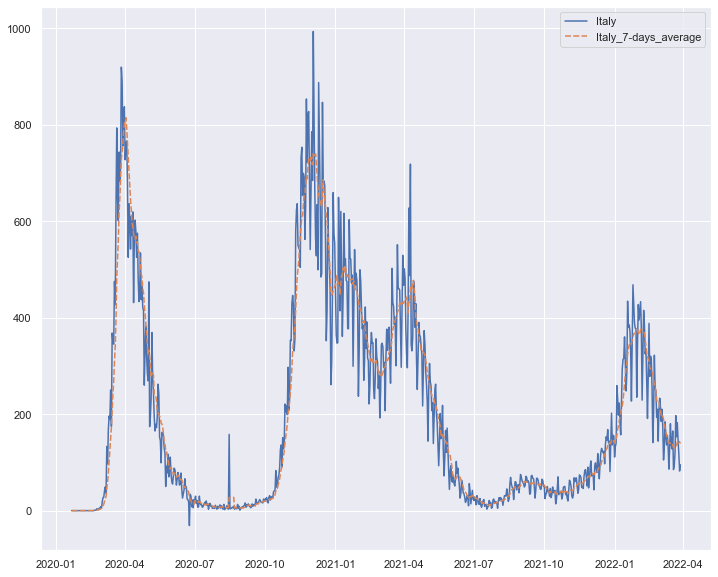

In [2]:
import seaborn as sns

sns.set(rc={'figure.figsize':(12,10)})
sns.set_theme()

sns.lineplot(data=[dataset["Italy"], dataset["Italy_7-days_average"]])

[Text(0.5, 1.0, 'Normalized Italy rolling_mean 7 days COVID Death')]

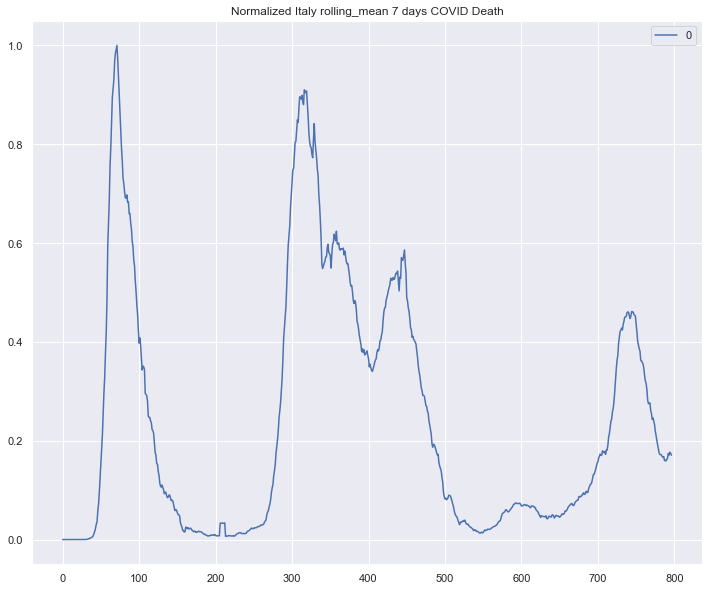

In [4]:
# Creating LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1 - normalize the dataset

ita_dataset = np.array(dataset["Italy_7-days_average"])
ita_dataset = ita_dataset.reshape(len(ita_dataset), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
ita_dataset = scaler.fit_transform(ita_dataset)

sns.lineplot(data=ita_dataset).set(title="Normalized Italy rolling_mean 7 days COVID Death")


In [5]:
# 2 - train,test split

train_size = int(len(ita_dataset) * 0.67)
test_size = len(ita_dataset) - train_size
train, test = ita_dataset[0:train_size,:], ita_dataset[train_size:len(ita_dataset),:]
print(len(train), len(test))

533 264


In [6]:
# 3 - features & label creation from time series (look_back use)

def create_dataset(dataset, look_back=1):
	X, Y = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		X.append(a)
		Y.append(dataset[i + look_back, 0])
	return np.array(X), np.array(Y)

# example : X=t and Y=t+1
look_back = 1
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features] as requested by LSTM NN
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [7]:
# 4 - Creating the NN model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [8]:
# 5 - Fine-tuning the model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=create_lstm_model)
param_grid = {"epochs" : range(20, 150, 10), "batch_size" :range(10,31, 5)}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_Y, verbose=1)

print(f"Best score : {round(grid_result.best_score_, 2)} using {grid_result.best_params_}")


C:\Users\jbezi\AppData\Local\Temp\ipykernel_22040\3289330063.py:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model)


Epoch 1/130
54/54 [==============================] - 4s 3ms/step - loss: 0.1368
Epoch 2/130
54/54 [==============================] - 0s 5ms/step - loss: 0.0868
Epoch 3/130
54/54 [==============================] - 0s 4ms/step - loss: 0.0621
Epoch 4/130
54/54 [==============================] - 0s 4ms/step - loss: 0.0495
Epoch 5/130
54/54 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 6/130
54/54 [==============================] - 0s 4ms/step - loss: 0.0354
Epoch 7/130
54/54 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 8/130
54/54 [==============================] - 0s 4ms/step - loss: 0.0239
Epoch 9/130
54/54 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 10/130
54/54 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 11/130
54/54 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 12/130
54/54 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 13/130
54/54 [=================

In [9]:
# fitting the best model
best_model = create_lstm_model()

best_model.fit(train_X, train_Y, **grid_result.best_params_, verbose=2)

Epoch 1/130
54/54 - 3s - loss: 0.1234 - 3s/epoch - 56ms/step
Epoch 2/130
54/54 - 0s - loss: 0.0861 - 121ms/epoch - 2ms/step
Epoch 3/130
54/54 - 0s - loss: 0.0643 - 152ms/epoch - 3ms/step
Epoch 4/130
54/54 - 0s - loss: 0.0514 - 127ms/epoch - 2ms/step
Epoch 5/130
54/54 - 0s - loss: 0.0433 - 155ms/epoch - 3ms/step
Epoch 6/130
54/54 - 0s - loss: 0.0365 - 117ms/epoch - 2ms/step
Epoch 7/130
54/54 - 0s - loss: 0.0299 - 117ms/epoch - 2ms/step
Epoch 8/130
54/54 - 0s - loss: 0.0232 - 124ms/epoch - 2ms/step
Epoch 9/130
54/54 - 0s - loss: 0.0170 - 123ms/epoch - 2ms/step
Epoch 10/130
54/54 - 0s - loss: 0.0117 - 121ms/epoch - 2ms/step
Epoch 11/130
54/54 - 0s - loss: 0.0073 - 119ms/epoch - 2ms/step
Epoch 12/130
54/54 - 0s - loss: 0.0042 - 171ms/epoch - 3ms/step
Epoch 13/130
54/54 - 0s - loss: 0.0023 - 110ms/epoch - 2ms/step
Epoch 14/130
54/54 - 0s - loss: 0.0012 - 118ms/epoch - 2ms/step
Epoch 15/130
54/54 - 0s - loss: 6.4510e-04 - 131ms/epoch - 2ms/step
Epoch 16/130
54/54 - 0s - loss: 4.1216e-04 - 12

Test Score: 0.01 (RMSE)


<AxesSubplot:>

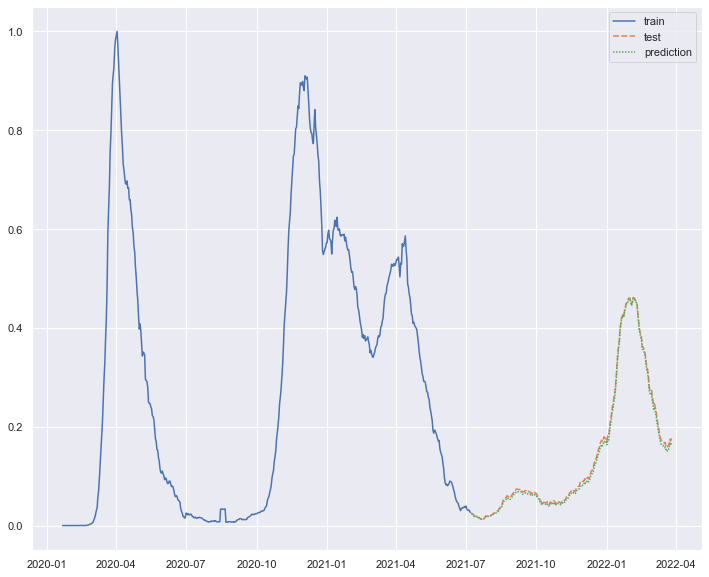

In [10]:
# 6 - predicting

import math
from sklearn.metrics import mean_squared_error
import pandas as pd

test_prediction = best_model.predict(test_X)
testScore = math.sqrt(mean_squared_error(test_Y, test_prediction[:,0]))
print(f"Test Score: {round(testScore, 2)} (RMSE)")

train_df = pd.DataFrame(train, index=dataset["Italy"].index[0:train_size], columns=["train"])
test_df = pd.DataFrame(test[:(-look_back-1)], index=dataset["Italy"].index[train_size:len(dataset["Italy"])-look_back-1], columns=["test"])
pred_df = pd.DataFrame(test_prediction, index=test_df.index)

df = pd.concat([train_df, test_df, pred_df], axis=1)
df.columns=["train" ,"test", "prediction"]
sns.lineplot(data=df)